This notebook contains the source code to reproduce the results of the Bayesian calibration and subsequent sensitivity analysis for the contaminant transport problem in the paper.

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

from MFU_representations import cFRADEMFU
from TruthModel import *

# Matplotlib options to get Times face and LaTeX for the paper.
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble']=r"\usepackage{amsmath,amssymb}"
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
import matplotlib.pyplot as plt

In [2]:
generalizedADE_truth_model = generalizedADETruthModel()

In [3]:
m = cFRADEMFU(generalizedADE_truth_model, lhood_sd=1e-2, Nt_calibration=20)

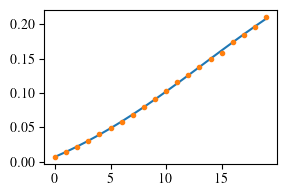

In [4]:
fig = plt.figure(figsize=(3,2))
plt.plot(np.exp(m.true_evolution))
plt.plot(np.exp(m.calibration_data), '.')

In [5]:
if os.path.exists(f'{m.results_dir}/mcmc_chain.h5'):
    m.load_mcmc_chain()
else:
    sol = m.optimize_for_map()
    theta0 = sol.x
    sol, theta0
    m.run_mcmc(20000, theta0=theta0)

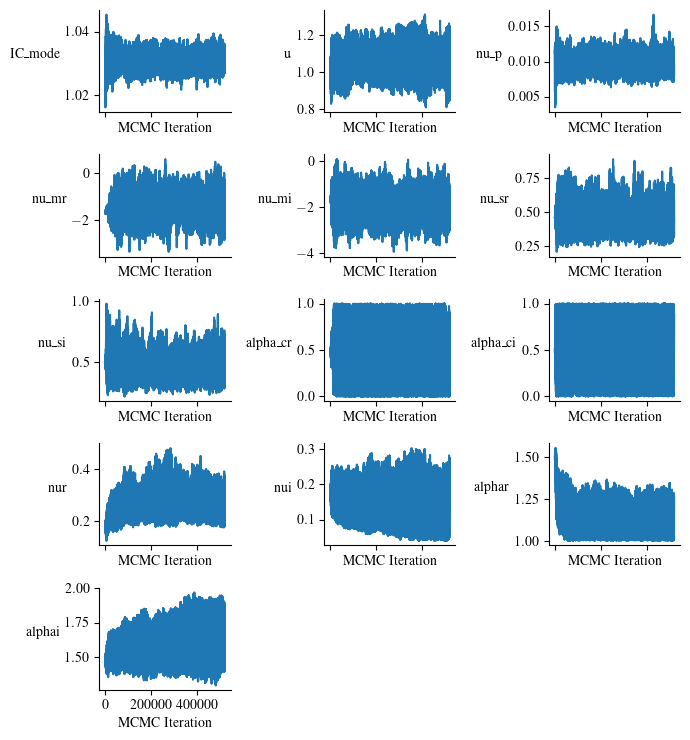

In [6]:
m.plot_mcmc_chains()

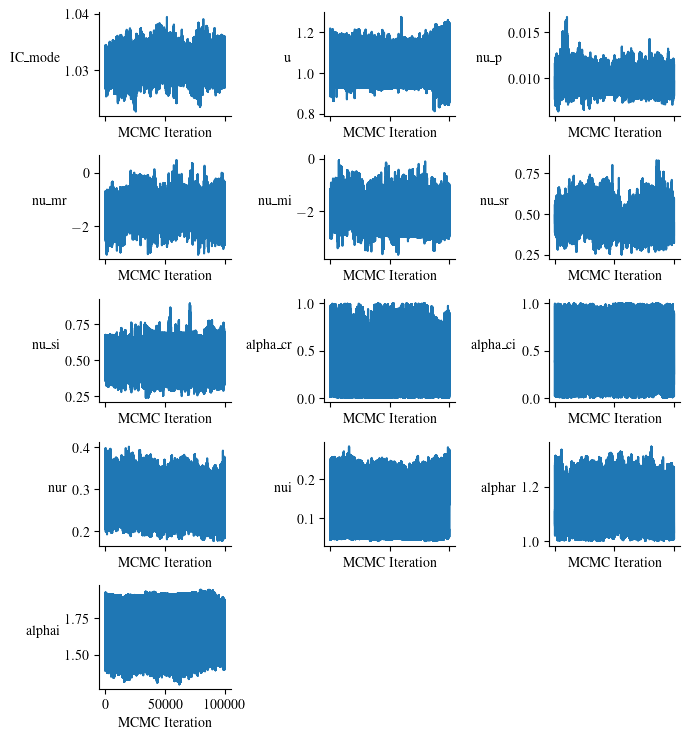

In [7]:
samples = m.chains[-100000:]
m.plot_mcmc_chains(samples)

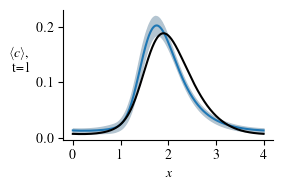

In [8]:
m.plot_spatial_pushforward(samples[::10],t=1)

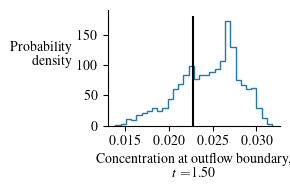

In [9]:
m.plot_qoi_pushforward(samples[::10])

In [10]:
np.random.seed(20250705)
reject_negative=False
pps = m.get_posterior_pushforward_samples(samples[::10], reject_negative=reject_negative)
prior_samples = m.get_prior_samples(pps.shape[0]*2, reject_negative=reject_negative)

In [11]:
pps_y = m.get_qoi_pushforward_samples(pps)
prior_y = m.get_qoi_pushforward_samples(prior_samples)

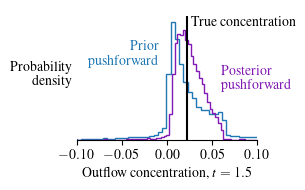

In [12]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(prior_y, density=True, histtype='step', bins=100);
ax.hist(pps_y, density=True, histtype='step', bins=100, color='#8119b5');

true_qoi = m.truth_model.f_field_from_eigenvalues()[-1]
ylim =  ax.get_ylim()[1]
ax.vlines(true_qoi, 0, ylim, 'k')
ax.annotate('True concentration', (true_qoi*1.2, ylim), va='top', ha='left')
ax.annotate('Prior\npushforward', (-0.01, 0.8*ylim), va='top', ha='right', color='C0')
ax.annotate('Posterior\npushforward', (0.06, 0.6*ylim), va='top', ha='left', color='#8119b5')

ax.set_yticks([])
ax.spines[['top','right', 'left']].set_visible(False)
ax.set_xlim([-0.1, 0.1]);

ax.set_xlabel(r'Outflow concentration, $t=1.5$');
ax.set_ylabel('Probability\ndensity', rotation=0, ha='right', va='center');
fig.tight_layout()
figdir = m.figdir
fig.savefig(f'{figdir}/qoi_pushforward_compare.pdf')

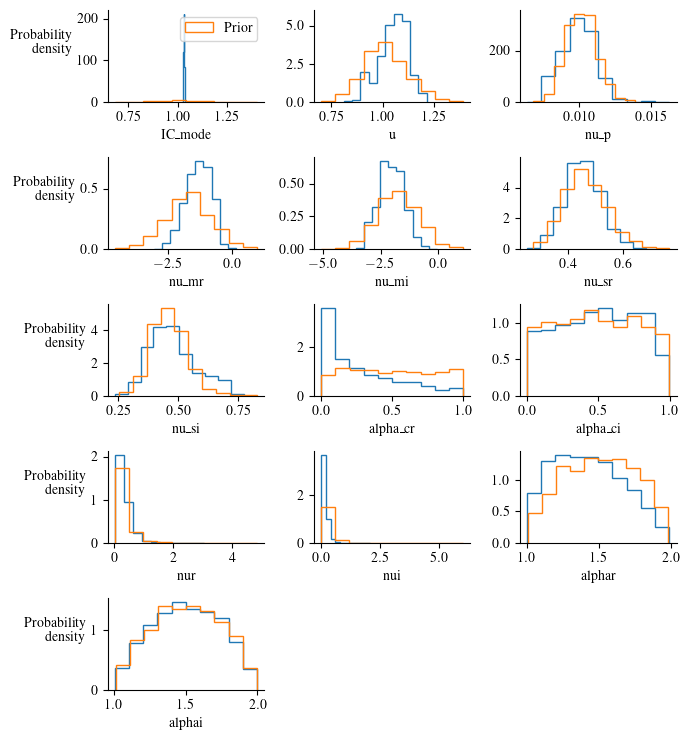

In [13]:
m.plot_marginal_histograms(pps, vs_prior=True)

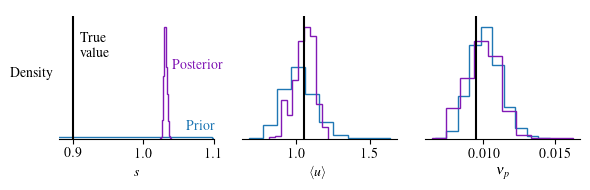

In [16]:
fig = plt.figure(figsize=(6,2))
axs = fig.subplots(1,3)

true_values = [generalizedADE_truth_model.IC_mode, generalizedADE_truth_model.u, generalizedADE_truth_model.nu_p]
for ax, si, si_pri, tv, label in zip(axs, pps.T, prior_samples.T, true_values, [r'$s$', r'$\langle u \rangle$', r'$\nu_p$']):
    ax.hist(si_pri, histtype='step', density=True);
    ax.hist(si, histtype='step', density=True, color='#8119b5');
    ax.vlines(tv, 0, ax.get_ylim()[1]*1.05, 'k');
    ax.set_xlabel(label)
    ax.set_yticks([])
    ax.spines[['left', 'top','right']].set_visible(False)

axs[0].set_xlim([0.88,1.1])

axs[0].annotate('Posterior', (1.04, 150), color='#8119b5', va='top')
axs[0].annotate('Prior', (1.06, 10), color='C0', va='bottom')
axs[0].annotate('True\nvalue', (0.91, 200), va='top')
axs[0].set_ylabel('Density', rotation=0, ha='right', va='center')

fig.tight_layout()
fig.savefig(f'{m.figdir}/model_param_posteriors_vs_true.pdf')

In [15]:
df = pd.DataFrame(pps, columns=m.parameter_names)
cc = df.corr().iloc[:-4,:-4]
cc = cc.iloc[:3,3:]
cc

,nu_mr,nu_mi,nu_sr,nu_si,alpha_cr,alpha_ci
IC_mode,-0.182055,-0.073254,0.101830,-0.109056,0.193237,-0.065725
u,0.065134,0.565872,-0.018859,-0.283660,0.077420,-0.260407
nu_p,-0.118068,0.097648,-0.134528,-0.277541,0.214990,-0.255525


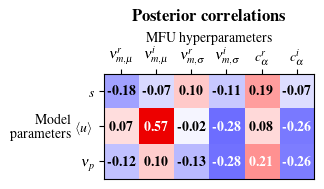

In [42]:
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.matshow(cc, vmin=-1, vmax=1, cmap='seismic')

ax.set_yticks(np.arange(3));
ax.set_yticklabels([r'$s$', r'$\langle u \rangle$', r'$\nu_p$'])

ax.set_xticks(np.arange(6));
ax.set_xticklabels([r'$\nu_{m,\mu}^r$', r'$\nu_{m,\mu}^i$', r'$\nu_{m,\sigma}^r$', r'$\nu_{m,\sigma}^i$',  r'$c_\alpha^r$', r'$c_\alpha^i$']);
ax.tick_params(axis='x', bottom=False)

for i in range(3):
    for j in range(6):
        val = cc.iloc[i,j]
        color = 'w' if np.abs(val) > 0.2 else 'k'
        ax.annotate(rf'\textbf{{{cc.iloc[i,j]:.2f}}}', (j,i), ha='center', va='center', color=color)

ax.set_ylabel('Model\nparameters', rotation=0, ha='right', va='center')
ax.set_xlabel('MFU hyperparameters')
ax.xaxis.set_label_position('top')  

ax.set_title(r'\textbf{Posterior correlations}', pad=8);
fig.tight_layout()
fig.savefig(f'{m.figdir}/posterior_correlations.pdf', bbox_inches='tight')

Now let's compare the Sobol' indices we get from prior to posterior.

# Sobol index computations

### Prior Sobol' indices

In [17]:
mprior = cFRADEMFU(generalizedADE_truth_model, lhood_sd=1e-2, Nt_calibration=20)

In [18]:
N = 100000
np.random.seed(20250705)
A = mprior.get_prior_samples(N)
B = mprior.get_prior_samples(N)
mprior.compute_sobol_indices(sample_tup=(A,B))

Iteration over group: 100%|██████████| 2/2 [00:06<00:00,  3.24s/it]


In [19]:
yprior = mprior.fX(mprior.get_prior_samples(1000))
yprior[yprior<0].size / yprior.size

0.082

In [20]:
mprior.results['Total Effects']

{IC_mode, u, ...}      0.183329
{nu_mr, nu_mi, ...}    0.995651
dtype: float64

In [21]:
mprior.V

array([0.00118851])

### Posterior Sobol' indices

To be able to generate enough IID samples we need to construct a KDE of the posterior.

Since the c variables are bounded $[0,1]$ we need to map them to an unbounded domain through the normal RV inverse CDF transform.

#### KDE construction

In [22]:
KDE_build_points = pps[:,:-m.n_MFU_params].copy()

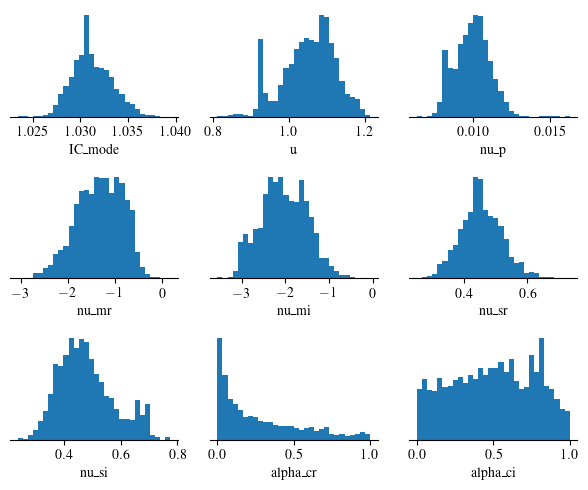

In [23]:
fig = plt.figure(figsize=(6,5))
axs = fig.subplots(3,3).flatten()
labels = m.parameter_names[:-m.n_MFU_params]
for ax, k, label in zip(axs,KDE_build_points.T, labels):
    ax.hist(k, bins=30);
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(label)
fig.tight_layout()

In [24]:
sn = ss.norm()
KDE_build_points[:,-2:] = sn.ppf(KDE_build_points[:,-2:])

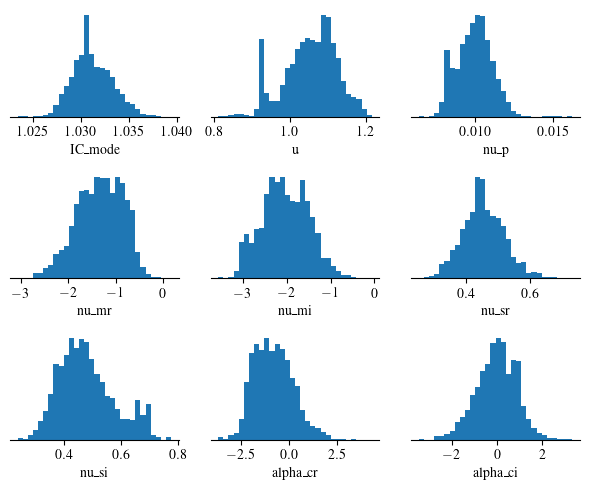

In [25]:
fig = plt.figure(figsize=(6,5))
axs = fig.subplots(3,3).flatten()
labels = m.parameter_names[:-m.n_MFU_params]
for ax, k, label in zip(axs,KDE_build_points.T, labels):
    ax.hist(k, bins=30);
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(label)
fig.tight_layout()

In [26]:
kde = ss.gaussian_kde(KDE_build_points.T)

How good is the reconstruction?

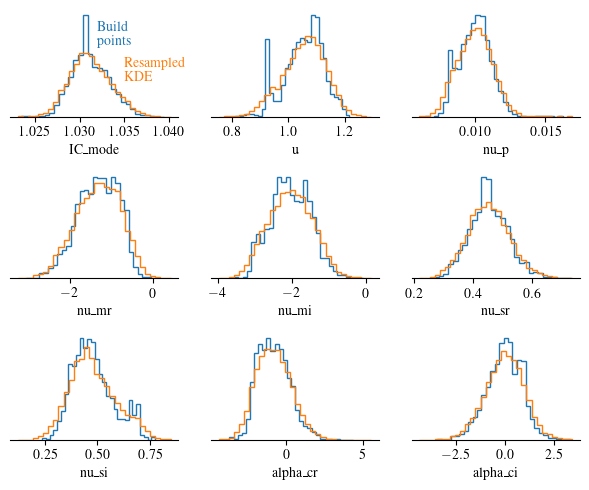

In [27]:
fig = plt.figure(figsize=(6,5))
axs = fig.subplots(3,3).flatten()
labels = m.parameter_names[:-m.n_MFU_params]

KDE_resampled = kde.resample(KDE_build_points.shape[0])
for ax, k, kr, label in zip(axs,KDE_build_points.T, KDE_resampled, labels):
    ax.hist(k, bins=30, density=True, histtype='step');
    ax.hist(kr, bins=30, density=True, histtype='step');
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(label)

axs[0].annotate('Build\npoints', (1.032, 200), color='C0')
axs[0].annotate('Resampled\nKDE', (1.035, 100), color='C1')
fig.tight_layout()

This looks fine for our purposes. However, let's also check pair plots.

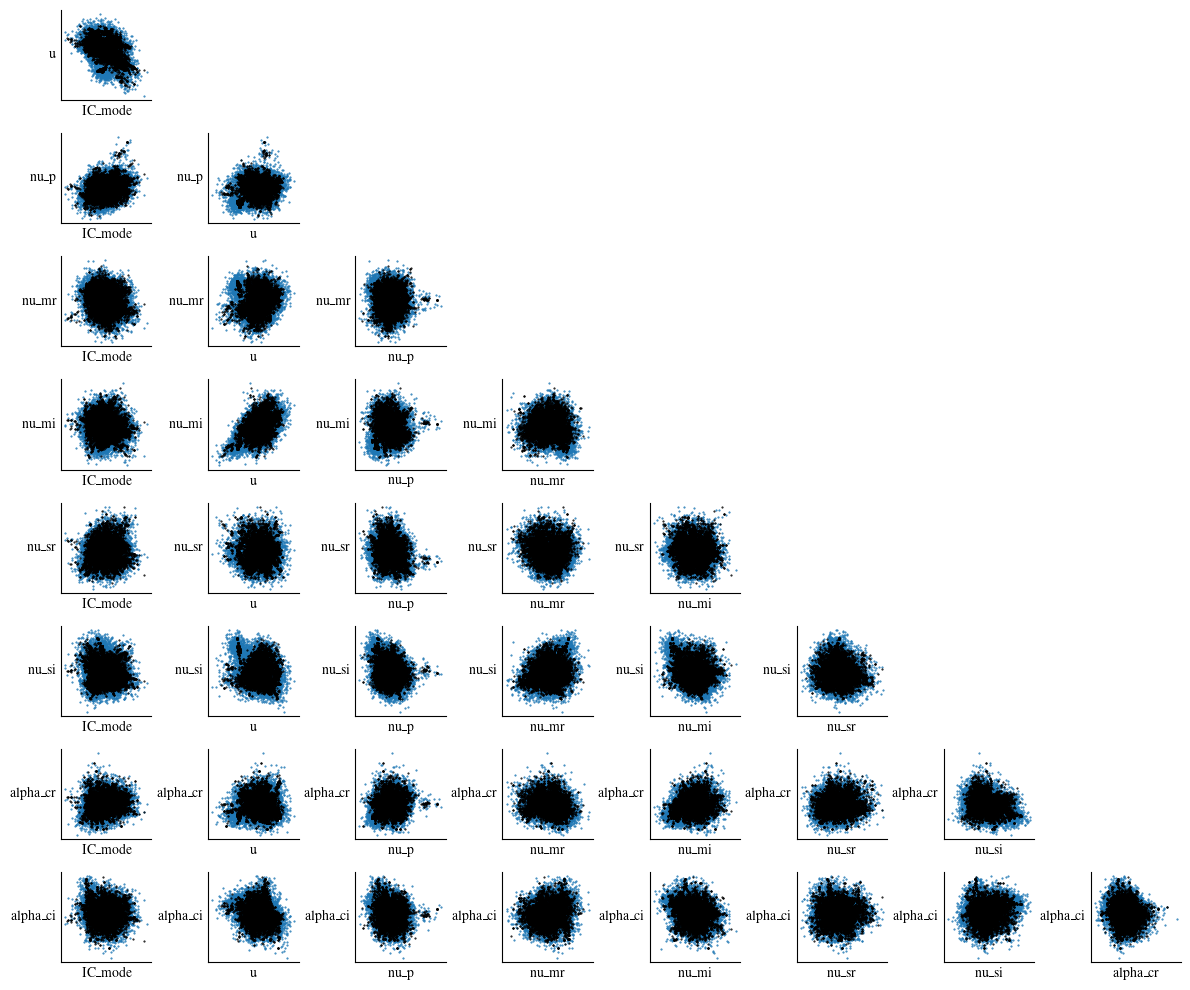

In [28]:
fig = plt.figure(figsize=(12,10))
axs = fig.subplots(8,8)
for i, (sample1, sample1r, label1) in enumerate(zip(KDE_build_points[:,:-1].T, KDE_resampled[:-1], labels[:-1])):
    for j, (sample2, sample2r, label2) in enumerate(zip(KDE_build_points[:,1:].T, KDE_resampled[1:], labels[1:])):

        ax = axs[j,i]
        if i > j:
            plt.delaxes(ax)

        ax.plot(sample1r, sample2r, 'C0.', ms=1, label='KDE resamples')

        ax.plot(sample1, sample2, 'k.', ms=1, label='Build points')
        ax.set_xlabel(label1)
        ax.set_ylabel(label2, rotation=0, ha='right', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_box_aspect(1)
        ax.spines[['top','right']].set_visible(False)

#axs[1,1].legend(bbox_to_anchor=(1,1))

fig.tight_layout()

I think this is capturing enough of the dependence structure to be representative.

Now we want to be able to generate samples of the full sample set.

#### Sobol' index computation

First let's verify that we are getting the right distributions in untransformed space.

In [29]:
def get_posterior_samples(N):
    X = np.zeros((N, m.n_params))
    X[:,:-m.n_MFU_params] = kde.resample(N).T

    # Now we need to rescale back the samples
    c_inds = [m.n_model_params+4,m.n_model_params+5]
    X[:,c_inds] = sn.cdf(X[:,c_inds])

    return m.get_posterior_pushforward_samples(X)

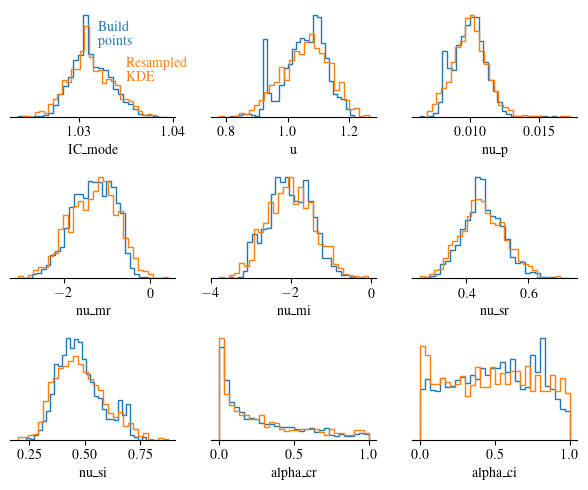

In [30]:
temp = pps[:,:-m.n_MFU_params]
X = get_posterior_samples(1000)

fig = plt.figure(figsize=(6,5))
axs = fig.subplots(3,3).flatten()
labels = m.parameter_names[:-m.n_MFU_params]

for ax, k, kr, label in zip(axs,temp.T, X.T, labels):
    ax.hist(k, bins=30, density=True, histtype='step');
    ax.hist(kr, bins=30, density=True, histtype='step');
    ax.set_yticks([])
    ax.spines[['top','left','right']].set_visible(False)
    ax.set_xlabel(label)

axs[0].annotate('Build\npoints', (1.032, 200), color='C0')
axs[0].annotate('Resampled\nKDE', (1.035, 100), color='C1')
fig.tight_layout()

Looks good. Now we can compute Sobol' indices.

In [31]:
N = 100000
np.random.seed(20250705)
A = get_posterior_samples(N)
B = get_posterior_samples(N)
m.compute_sobol_indices(sample_tup=(A,B))

Iteration over group: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


In [32]:
yposterior = m.fX(get_posterior_samples(1000))
yposterior[yposterior<0].size / yposterior.size

0.024

In [33]:
m.results['Total Effects']

{IC_mode, u, ...}      0.050896
{nu_mr, nu_mi, ...}    1.008382
dtype: float64

In [34]:
m.V

array([0.00032913])

In [35]:
np.random.seed(20250705)
yprior = mprior.fX(mprior.get_prior_samples(10000))
ykde = m.fX(get_posterior_samples(10000))

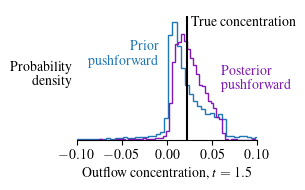

In [ ]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.hist(yprior, density=True, histtype='step', bins=100);
ax.hist(ykde, density=True, histtype='step', bins=100, color='#8119b5');

true_qoi = m.truth_model.f_field_from_eigenvalues()[-1]
ylim =  ax.get_ylim()[1]
ax.vlines(true_qoi, 0, ylim, 'k')
ax.annotate('True concentration', (true_qoi*1.2, ylim), va='top', ha='left')
ax.annotate('Prior\npushforward', (-0.01, 0.8*ylim), va='top', ha='right', color='C0')
ax.annotate('Posterior\npushforward', (0.06, 0.6*ylim), va='top', ha='left', color='#8119b5')

ax.set_yticks([])
ax.spines[['top','right', 'left']].set_visible(False)
ax.set_xlim([-0.1, 0.1]);

ax.set_xlabel(r'Outflow concentration, $t=1.5$');
ax.set_ylabel('Probability\ndensity', rotation=0, ha='right', va='center');
fig.tight_layout()
figdir = m.figdir
fig.savefig(f'{figdir}/qoi_pushforward_compare.pdf')

In [37]:
mprior.V, m.V

(array([0.00118851]), array([0.00032913]))

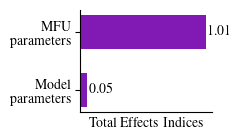

In [38]:
fig = plt.figure(figsize=(2.5,1.5))
ax = fig.add_subplot(111)

inds=np.arange(2)
Tpost = m.results['Total Effects'].to_numpy()
ax.barh(inds, Tpost, height=0.6, color='#8119b5');
for i, v in zip(inds,Tpost):
    ax.annotate(f'{v:.2f}', (v+.015,i), ha='left', va='center')
ax.set_yticks(inds)
ax.set_yticklabels(['Model\nparameters', 'MFU\nparameters'])
ax.set_xticks([])
ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('Total Effects Indices')

fig.tight_layout()
fig.savefig(f'{m.figdir}/total_effects_indices.pdf')

In [39]:
prior_numerators = mprior.results['Total Effects'] * mprior.V
posterior_numerators = m.results['Total Effects'] * m.V

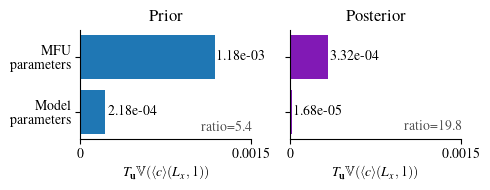

In [40]:
fig = plt.figure(figsize=(5,2))
axs = fig.subplots(1, 2, sharex=True)

inds=np.arange(2)
axs[0].set_title('Prior')
axs[0].barh(inds,prior_numerators, height=0.8)
for x, y in zip(prior_numerators.to_numpy(), inds):
    axs[0].annotate(f'{x:.2e}', (x+.00002,y), va='center')
ratio = prior_numerators.iloc[1]/prior_numerators.iloc[0]
axs[0].annotate(f'ratio={ratio:.1f}', (.0015,-.4), ha='right', va='bottom', color='#545454')

axs[1].set_title('Posterior')
axs[1].barh(inds,posterior_numerators, color='#8119b5')
for x, y in zip(posterior_numerators.to_numpy(), inds):
    axs[1].annotate(f'{x:.2e}', (x+.00002,y), va='center')
ratio = posterior_numerators.iloc[1]/posterior_numerators.iloc[0] 
axs[1].annotate(f'ratio={ratio:.1f}', (.0015,-.4), ha='right', va='bottom', color='#545454')

for ax in axs:
    ax.set_yticks(inds)
    ax.spines[['top','right']].set_visible(False)
    ax.set_xticks([0,.0015])
    ax.set_xticklabels([0,0.0015])
    ax.set_xlabel(r'$T_{\mathbf{u}} \mathbb{V}(\langle c \rangle(L_x,1))$')

axs[0].set_yticklabels(['Model\nparameters', 'MFU\nparameters'])
axs[1].set_yticklabels([])


fig.tight_layout()
fig.savefig(f'{m.figdir}/prior_vs_posterior_numerators.pdf', bbox_inches='tight')